In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nitishabharathi/cert-insider-threat")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\pc\.cache\kagglehub\datasets\nitishabharathi\cert-insider-threat\versions\1


In [4]:
import os
import re
import string
import nltk
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Download necessary NLTK resources
nltk.download("stopwords")
nltk.download("punkt")

# List all files in the dataset directory
files = os.listdir(path)
print("Dataset Files:", files)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...


Dataset Files: ['email.csv', 'psychometric.csv']


[nltk_data]   Package punkt is already up-to-date!


In [6]:
import pandas as pd
import numpy as np

df = pd.read_csv(os.path.join(path, "email.csv"))
# Map Threat column to numerical (Yes -> 1, No -> 0)
df["Threat"] = np.random.choice(["Yes", "No"], size=len(df), p=[0.5, 0.5])
df["Threat"] = df["Threat"].map({"Yes": 1, "No": 0})
# Display first few rows
print(df.head(5))


                         id                 date     user       pc  \
0  {R3I7-S4TX96FG-8219JWFF}  01/02/2010 07:11:45  LAP0338  PC-5758   
1  {R0R9-E4GL59IK-2907OSWJ}  01/02/2010 07:12:16  MOH0273  PC-6699   
2  {G2B2-A8XY58CP-2847ZJZL}  01/02/2010 07:13:00  LAP0338  PC-5758   
3  {A3A9-F4TH89AA-8318GFGK}  01/02/2010 07:13:17  LAP0338  PC-5758   
4  {E8B7-C8FZ88UF-2946RUQQ}  01/02/2010 07:13:28  MOH0273  PC-6699   

                                                  to  \
0  Dean.Flynn.Hines@dtaa.com;Wade_Harrison@lockhe...   
1                        Odonnell-Gage@bellsouth.net   
2                         Penelope_Colon@netzero.com   
3                          Judith_Hayden@comcast.net   
4  Bond-Raymond@verizon.net;Alea_Ferrell@msn.com;...   

                                cc                          bcc  \
0  Nathaniel.Hunter.Heath@dtaa.com                          NaN   
1                              NaN                          NaN   
2                              NaN       

In [7]:
print("Dataset Shape:", df.shape)

print(df.info())  # Overview of columns and data types
print(df.describe())  # Summary statistics
print(df.isnull().sum())  # Count of missing values

Dataset Shape: (2629979, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2629979 entries, 0 to 2629978
Data columns (total 12 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   id           object
 1   date         object
 2   user         object
 3   pc           object
 4   to           object
 5   cc           object
 6   bcc          object
 7   from         object
 8   size         int64 
 9   attachments  int64 
 10  content      object
 11  Threat       int64 
dtypes: int64(3), object(9)
memory usage: 240.8+ MB
None
               size   attachments        Threat
count  2.629979e+06  2.629979e+06  2.629979e+06
mean   2.999232e+04  4.035960e-01  5.003439e-01
std    9.993642e+03  1.049910e+00  5.000000e-01
min    6.182000e+03  0.000000e+00  0.000000e+00
25%    2.285900e+04  0.000000e+00  0.000000e+00
50%    2.845500e+04  0.000000e+00  1.000000e+00
75%    3.541800e+04  0.000000e+00  1.000000e+00
max    1.419090e+05  9.000000e+00  1.000000e+00
id                 

In [8]:
from nltk.corpus import stopwords
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))
# Function to preprocess text
def preprocess_text(text):
    if not isinstance(text, str):  # Handle missing or non-string values
        return ""
    
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"\d+", "", text)  # Remove numbers
    text = text.translate(str.maketrans("", "", string.punctuation))  # Remove punctuation
    text = " ".join(word for word in text.split() if word not in stop_words)  # Remove stopwords
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
df_sample = df.sample(n=20000, random_state=42)  # Use 10,000 samples


In [10]:
# Apply text preprocessing
df_sample["content"] = df_sample["content"].astype(str)
df_sample["clean_content"] = df_sample["content"].apply(preprocess_text)


In [11]:
vectorizer = TfidfVectorizer(max_features=1000)
X_text = vectorizer.fit_transform(df_sample["clean_content"])

# Convert to DataFrame with actual words as column names
X_text_df = pd.DataFrame(X_text.toarray(), columns=vectorizer.get_feature_names_out())

X_text_df = X_text_df.reset_index(drop=True)
df_features = df_sample[["size", "attachments"]].reset_index(drop=True)

X = pd.concat([X_text_df, df_features], axis=1)
y = df_sample["Threat"]

In [12]:
print(len(X), len(y))  # They should be the same


20000 20000


In [13]:
# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Function to train model and return accuracy
def train_and_evaluate(X_train, X_test, y_train, y_test):
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

# Baseline Model (Raw Data)
accuracy_baseline = train_and_evaluate(X_train, X_test, y_train, y_test)
print("Baseline Model Accuracy (Raw Data):", accuracy_baseline)

Baseline Model Accuracy (Raw Data): 0.5005


In [15]:

def train_and_evaluate(X_train, X_test, y_train, y_test):
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)


#after encoding
accuracy_encoding = train_and_evaluate(X_train, X_test, y_train, y_test)
print("encoding model accuracy:", accuracy_encoding)

encoding model accuracy: 0.5005


In [ ]:
# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
accuracy_standardized = train_and_evaluate(X_train_scaled, X_test_scaled, y_train, y_test)
print("Standardized Model Accuracy:", accuracy_standardized)

Standardized Model Accuracy: 0.4985


In [17]:
# Feature Selection (Select best 3000 features)
selector = SelectKBest(chi2, k=3000)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
accuracy_feature_selection = train_and_evaluate(X_train_selected, X_test_selected, y_train, y_test)
print("Feature Selection Model Accuracy:", accuracy_feature_selection)

C:\Users\pc\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=3000 is greater than n_features=1002. All the features will be returned.
  warnings.warn(


Feature Selection Model Accuracy: 0.5005


In [ ]:
# SMOTE (Handle Imbalanced Data)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
accuracy_smote = train_and_evaluate(X_train_smote, X_test, y_train_smote, y_test)

print("SMOTE Model Accuracy:", accuracy_smote)

SMOTE Model Accuracy: 0.50025


In [19]:
# PCA (Reduce to 300 components)
pca = PCA(n_components=300)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
accuracy_pca = train_and_evaluate(X_train_pca, X_test_pca, y_train, y_test)
print("PCA Model Accuracy:", accuracy_pca)  

PCA Model Accuracy: 0.505


dict_values([0.5005, 0.4985, 0.50025, 0.5005, 0.505, 0.5005])


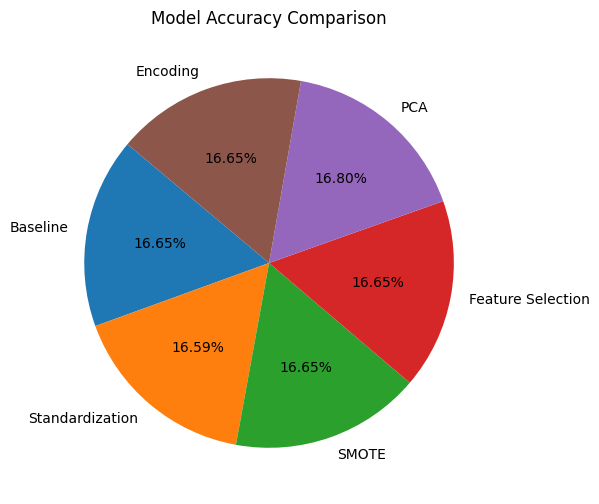

In [23]:
# Store Accuracy Scores
accuracy_percentages = {
    "Baseline": accuracy_baseline ,
    "Standardization": accuracy_standardized,
    "SMOTE": accuracy_smote ,
    "Feature Selection": accuracy_feature_selection ,
    "PCA": accuracy_pca ,
    "Encoding": accuracy_encoding
}
print(accuracy_percentages.values())
# Pie chart
# Divide each value by the number of categories to make them sum to 100%
num_categories = len(accuracy_percentages)
accuracy_percentages = {k: v / num_categories for k, v in accuracy_percentages.items()}

# Plot the pie chart
plt.figure(figsize=(6, 6))
plt.pie(accuracy_percentages.values(), labels=accuracy_percentages.keys(), autopct='%1.2f%%', startangle=140,normalize=True)
plt.title("Model Accuracy Comparison")
plt.show()

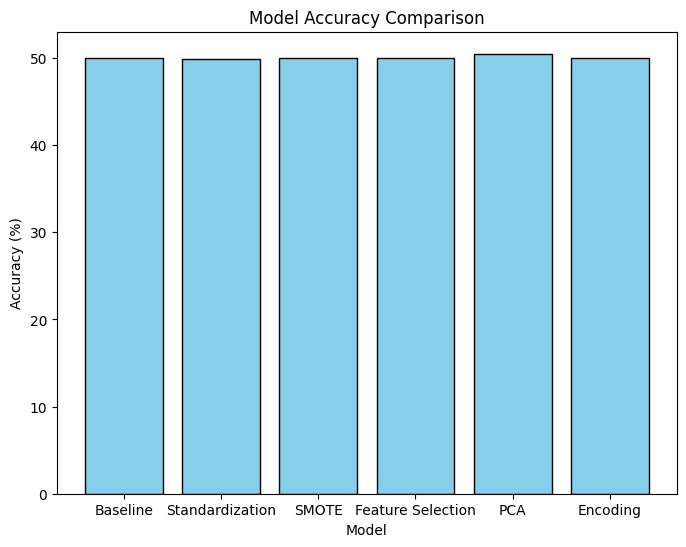

In [21]:
accuracies = [
    ("Baseline", accuracy_baseline * 100),
    ("Standardization", accuracy_standardized * 100),
    ("SMOTE", accuracy_smote * 100),
    ("Feature Selection", accuracy_feature_selection * 100),
    ("PCA",accuracy_pca * 100),
    ("Encoding",accuracy_encoding * 100)
]

# Extract model names and accuracy values
model_names = [model[0] for model in accuracies]
accuracy_values = [model[1] for model in accuracies]

# Create the histogram
plt.figure(figsize=(8, 6))
plt.bar(model_names, accuracy_values, color='skyblue', edgecolor='black')

# Add title and labels
plt.title("Model Accuracy Comparison")
plt.xlabel("Model")
plt.ylabel("Accuracy (%)")

# Show the plot
plt.show()

In [22]:
accuracies = [
    ("Baseline", accuracy_baseline * 100),
    ("Standardization",accuracy_standardized * 100),
   
    ("SMOTE", accuracy_smote * 100),
    ("Feature Selection", accuracy_feature_selection * 100),
    ("PCA", accuracy_pca* 100),
    ("Encoding",accuracy_encoding * 100)
]

# Convert the list into a DataFrame
accuracy_df = pd.DataFrame(accuracies, columns=["Model", "Accuracy (%)"])

# Display the table
print(accuracy_df)

               Model  Accuracy (%)
0           Baseline        50.050
1    Standardization        49.850
2              SMOTE        50.025
3  Feature Selection        50.050
4                PCA        50.500
5           Encoding        50.050
